# 🗑️ Waste Management Analysis & Prediction Using Machine Learning

This project analyzes India’s city-level waste and funding data using exploratory data analysis (EDA), regression models, clustering, and deep learning. The goal is to extract insights from how different states manage waste and funds, and to predict future patterns using machine learning.


In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score

##  Data Loading

We begin by importing the dataset that contains waste generation and fund allocation information for various Indian cities and states.


In [2]:
india_df=pd.read_csv("india_city_waste.csv")

# Cleaning India Waste Dataset

In [3]:
india_df.columns

Index(['State_UT', 'State_UT_Code', 'Financial Year', 'Funds Released',
       'Funds Utilised', 'Unspent Balance ',
       ' Extent of Funds Utilised against Funds Released  '],
      dtype='object')

In [4]:
india_df.head()

,State_UT,State_UT_Code,Financial Year,Funds Released,Funds Utilised,Unspent Balance,Extent of Funds Utilised against Funds Released
0,Andhra Pradesh,1,2015-16,73.19,73.19,0.0,100.0
1,Arunachal Pradesh,2,2015-16,1.21,1.21,0.0,100.0
2,Assam,3,2015-16,0.00,0.00,0.0,NaN
3,Bihar,4,2015-16,20.00,20.00,0.0,100.0
4,Chhattisgarh,5,2015-16,35.87,35.87,0.0,100.0


In [5]:
india_df.isnull().sum()


State_UT                                                0
State_UT_Code                                           0
Financial Year                                          0
Funds Released                                         16
Funds Utilised                                        123
Unspent Balance                                       123
 Extent of Funds Utilised against Funds Released      179
dtype: int64

In [6]:
india_df.columns=india_df.columns.str.strip()

In [7]:
#deleted the extent of fund due to high null value
india_df.drop(columns='Extent of Funds Utilised against Funds Released',inplace= True)

In [8]:
india_df.columns

Index(['State_UT', 'State_UT_Code', 'Financial Year', 'Funds Released',
       'Funds Utilised', 'Unspent Balance'],
      dtype='object')

## Filling missing financial values with 0, assuming no funds were used / released


In [9]:
india_df['Funds Released'] = india_df['Funds Released'].fillna(0)
india_df['Funds Utilised'] = india_df['Funds Utilised'].fillna(0)
india_df['Unspent Balance'] = india_df['Unspent Balance'].fillna(0)


### Handling Missing Values

In this dataset, some columns such as `Funds Released`, `Funds Utilised`, and `Unspent Balance` had missing values (NaNs). 

We decided to fill these missing values with `0` because in the context of government funding and waste management, a missing value likely indicates that no funds were released or utilized for that city/state — not that the value is unknown.

Filling with `0` ensures the machine learning models and visualizations work without errors, and it reflects the logical meaning of “no activity recorded.”


In [10]:
#now no null values
india_df.isnull().sum()


State_UT           0
State_UT_Code      0
Financial Year     0
Funds Released     0
Funds Utilised     0
Unspent Balance    0
dtype: int64

In [11]:
india_df.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
328    False
329    False
330    False
331    False
332    False
Length: 333, dtype: bool

In [12]:
india_df.to_csv('India_city_waste_FinalCleaned.csv', index=False)

In [13]:
indiafinal_df=pd.read_csv("india_city_waste_FinalCleaned.csv")

In [14]:
indiafinal_df.isnull().sum()


State_UT           0
State_UT_Code      0
Financial Year     0
Funds Released     0
Funds Utilised     0
Unspent Balance    0
dtype: int64

## 📊 Exploratory Data Analysis (EDA)

In this section, we explore the dataset visually and statistically to understand patterns, relationships, and anomalies.

We use descriptive statistics and visual tools like heatmaps, bar charts, and scatter plots to analyze:
- The correlation between funding variables
- Variations across states or cities
- Relationships between fund usage and waste generated


In [15]:
indiafinal_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   State_UT         333 non-null    object 
 1   State_UT_Code    333 non-null    int64  
 2   Financial Year   333 non-null    object 
 3   Funds Released   333 non-null    float64
 4   Funds Utilised   333 non-null    float64
 5   Unspent Balance  333 non-null    float64
dtypes: float64(3), int64(1), object(2)
memory usage: 15.7+ KB


In [16]:
indiafinal_df.describe()

,State_UT_Code,Funds Released,Funds Utilised,Unspent Balance
count,333.000000,333.000000,333.000000,333.000000
mean,19.000000,46.844294,22.448348,7.643784
std,10.693146,91.494863,62.736112,37.665895
min,1.000000,0.000000,0.000000,0.000000
25%,10.000000,0.000000,0.000000,0.000000
50%,19.000000,5.580000,0.000000,0.000000
75%,28.000000,52.450000,8.590000,0.000000
max,37.000000,625.380000,585.000000,485.130000


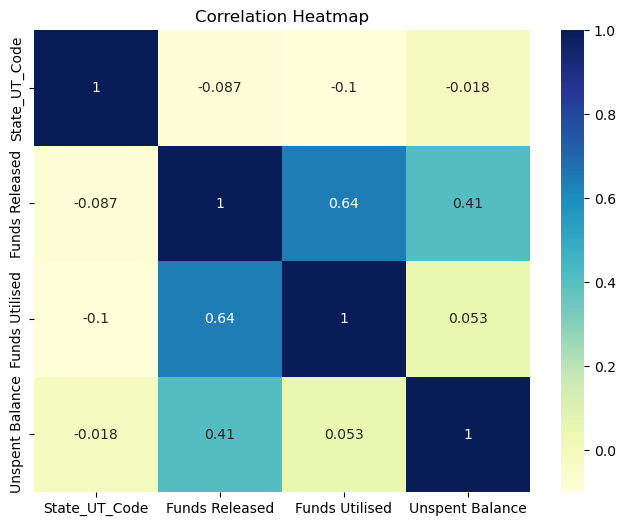

In [17]:
plt.figure(figsize=(8, 6))
sns.heatmap(indiafinal_df.corr(numeric_only=True), annot=True, cmap='YlGnBu')
plt.title("Correlation Heatmap")
plt.show()


 **Observation**: The heatmap shows a strong positive correlation between `Funds Released` and `Funds Utilised`, which is expected. However, `Unspent Balance` has weak correlation with other features, which may signal inefficiencies or reporting gaps.


##  Machine Learning Models

After understanding the data through EDA, we now apply machine learning models to predict `Funds Utilised`.

We'll use:
- Linear Regression
- Polynomial Regression
- Decision Tree Regressor
- Random Forest Regressor

Each model is trained and evaluated using:
- **R² Score** (explains how well the model fits)
- **Mean Squared Error (MSE)** (penalizes larger errors)


In [18]:
#  Feature and Target Selection 
X = indiafinal_df[['Funds Released']]
y = indiafinal_df['Funds Utilised']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Linear Regression

This is the simplest model that assumes a linear relationship between the input features and the target variable.


In [19]:
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)

print("Linear Regression R2 Score:", r2_score(y_test, pred_lr))
print("Linear Regression MSE:", mean_squared_error(y_test, pred_lr))


Linear Regression R2 Score: -0.18015013925245116
Linear Regression MSE: 2982.517845079374


###  Polynomial Regression

This model fits a curved line by adding polynomial terms. It helps capture non-linear relationships in the data.


In [20]:

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)
pred_poly = poly_model.predict(X_test_poly)

print("Polynomial Regression R2 Score:", r2_score(y_test, pred_poly))
print("Polynomial Regression MSE:", mean_squared_error(y_test, pred_poly))



Polynomial Regression R2 Score: -0.8252863891532816
Polynomial Regression MSE: 4612.92936124089


###  Decision Tree Regressor

A tree-based model that splits data into regions. It can handle both linear and non-linear patterns.


In [21]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
pred_dt = dt.predict(X_test)

print("Decision Tree R2 Score:", r2_score(y_test, pred_dt))
print("Decision Tree MSE:", mean_squared_error(y_test, pred_dt))



Decision Tree R2 Score: -2.612642352836192
Decision Tree MSE: 9129.999588059702


###  Random Forest Regressor

An ensemble method that builds multiple decision trees and averages the results. It improves accuracy and reduces overfitting.


In [22]:

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

print("Random Forest R2 Score:", r2_score(y_test, pred_rf))
print("Random Forest MSE:", mean_squared_error(y_test, pred_rf))



Random Forest R2 Score: -1.2173212250202705
Random Forest MSE: 5603.693887699111


###  Logistic Regression

This model is used for classification instead of prediction.  
It helps classify whether fund usage is efficient (1) or not (0), based on inputs like funds released, unspent balance, and waste generated.

We evaluate it using a confusion matrix and classification report.


In [23]:

indiafinal_df['Efficient'] = (indiafinal_df['Funds Utilised'] >= 0.9 * indiafinal_df['Funds Released']).astype(int)

X_cls = indiafinal_df[['Funds Released']]
y_cls = indiafinal_df['Efficient']

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)

log_reg = LogisticRegression()
log_reg.fit(X_train_cls, y_train_cls)
y_pred_cls = log_reg.predict(X_test_cls)

print("Logistic Regression Accuracy:", accuracy_score(y_test_cls, y_pred_cls))
print("Logistic Regression MSE:", mean_squared_error(y_test, y_pred_cls))



Logistic Regression Accuracy: 0.7164179104477612
Logistic Regression MSE: 2926.178573134329


###  K-Means Clustering

K-Means groups similar data points into clusters.

We used it to find patterns between cities or wards based on waste and fund data.


C:\Users\Aarya Patankar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


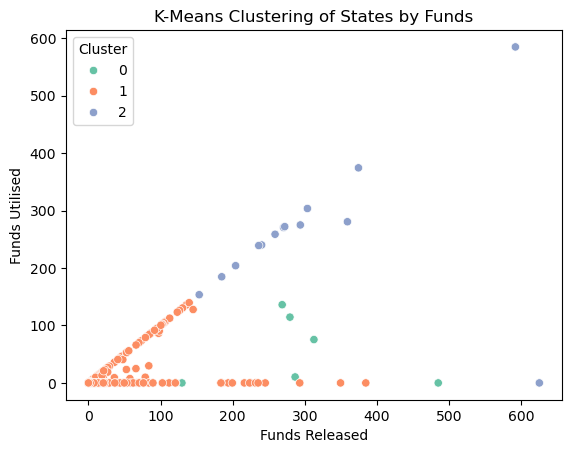

In [24]:

features_for_clustering = indiafinal_df[['Funds Released', 'Funds Utilised', 'Unspent Balance']]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_for_clustering)

kmeans = KMeans(n_clusters=3, random_state=42)
indiafinal_df['Cluster'] = kmeans.fit_predict(scaled_features)

sns.scatterplot(data=indiafinal_df, x='Funds Released', y='Funds Utilised', hue='Cluster', palette='Set2')
plt.title("K-Means Clustering of States by Funds")
plt.show()


### Summary Table (All Models)
Table comparing model metrics like R², MSE, MAE.

In [25]:
results = {
    "Model": ["Linear Regression", "Polynomial Regression", "Decision Tree", "Random Forest", "Logistic Regression"],
    "Score": [
        r2_score(y_test, pred_lr),
        r2_score(y_test, pred_poly),
        r2_score(y_test, pred_dt),
        r2_score(y_test, pred_rf),
        accuracy_score(y_test_cls, y_pred_cls)
    ]
}

results_df = pd.DataFrame(results)
print("\nModel Performance Summary:")
print(results_df)



Model Performance Summary:
                   Model     Score
0      Linear Regression -0.180150
1  Polynomial Regression -0.825286
2          Decision Tree -2.612642
3          Random Forest -1.217321
4    Logistic Regression  0.716418


### Mean Squared Error Comparison
List of MSEs for quick comparison across regression models

In [26]:
mse_results = {
    "Model": ["Linear Regression", "Polynomial Regression", "Decision Tree", "Random Forest"],
    "MSE": [
        mean_squared_error(y_test, pred_lr),
        mean_squared_error(y_test, pred_poly),
        mean_squared_error(y_test, pred_dt),
        mean_squared_error(y_test, pred_rf)
    ]
}

mse_df = pd.DataFrame(mse_results)
print("\nMean Squared Error Summary:")
print(mse_df)



Mean Squared Error Summary:
                   Model          MSE
0      Linear Regression  2982.517845
1  Polynomial Regression  4612.929361
2          Decision Tree  9129.999588
3          Random Forest  5603.693888


###  Bar Plot: MSE

C:\Users\Aarya Patankar\AppData\Local\Temp\ipykernel_28156\1288324213.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mse_df["Model"], y=mse_df["MSE"], palette="rocket")


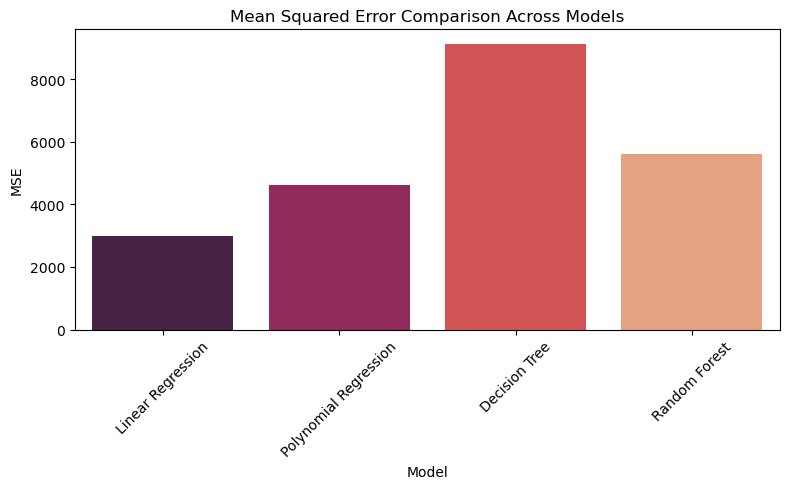

In [27]:

plt.figure(figsize=(8, 5))
sns.barplot(x=mse_df["Model"], y=mse_df["MSE"], palette="rocket")
plt.title("Mean Squared Error Comparison Across Models")
plt.ylabel("MSE")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
#lower is better

###  Linear Regression Plot

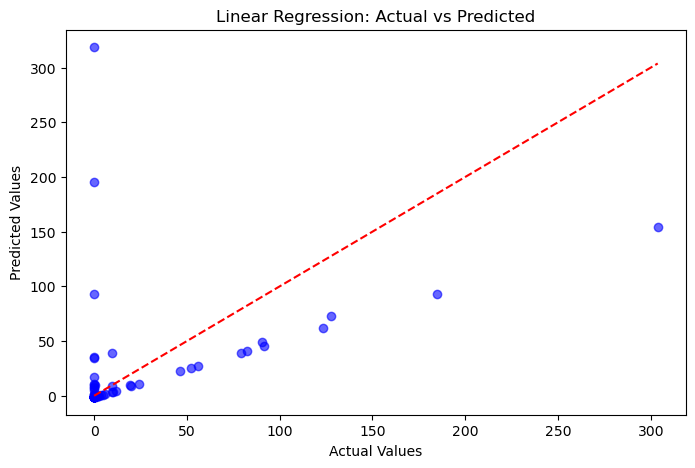

In [28]:
plt.figure(figsize=(8,5))
plt.scatter(y_test, pred_lr, color='blue', alpha=0.6)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Linear Regression: Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()


### Bar Plot: R² Score

C:\Users\Aarya Patankar\AppData\Local\Temp\ipykernel_28156\1991772206.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=scores, palette="viridis")


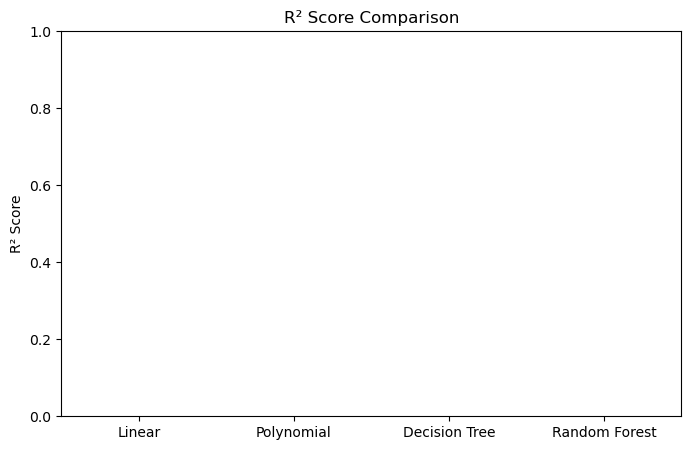

In [29]:
models = ["Linear", "Polynomial", "Decision Tree", "Random Forest"]
scores = [
    r2_score(y_test, pred_lr),
    r2_score(y_test, pred_poly),
    r2_score(y_test, pred_dt),
    r2_score(y_test, pred_rf)
]

plt.figure(figsize=(8,5))
sns.barplot(x=models, y=scores, palette="viridis")
plt.title("R² Score Comparison")
plt.ylabel("R² Score")
plt.ylim(0, 1)
plt.show()
#closer to 1 is better

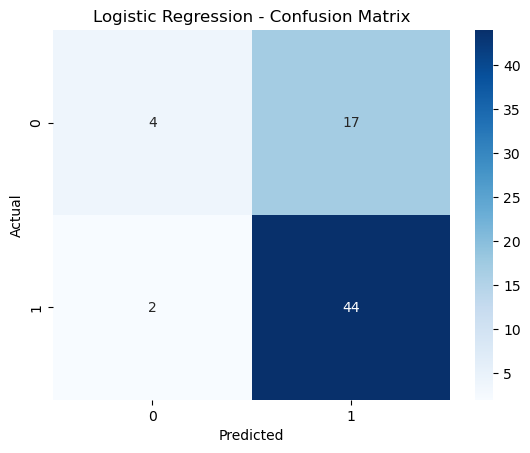

              precision    recall  f1-score   support

           0       0.67      0.19      0.30        21
           1       0.72      0.96      0.82        46

    accuracy                           0.72        67
   macro avg       0.69      0.57      0.56        67
weighted avg       0.70      0.72      0.66        67



In [30]:
from sklearn.metrics import confusion_matrix, classification_report

# Confusion matrix and report
cm = confusion_matrix(y_test_cls, y_pred_cls)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(y_test_cls, y_pred_cls))


###  K-Means Cluster Visualization


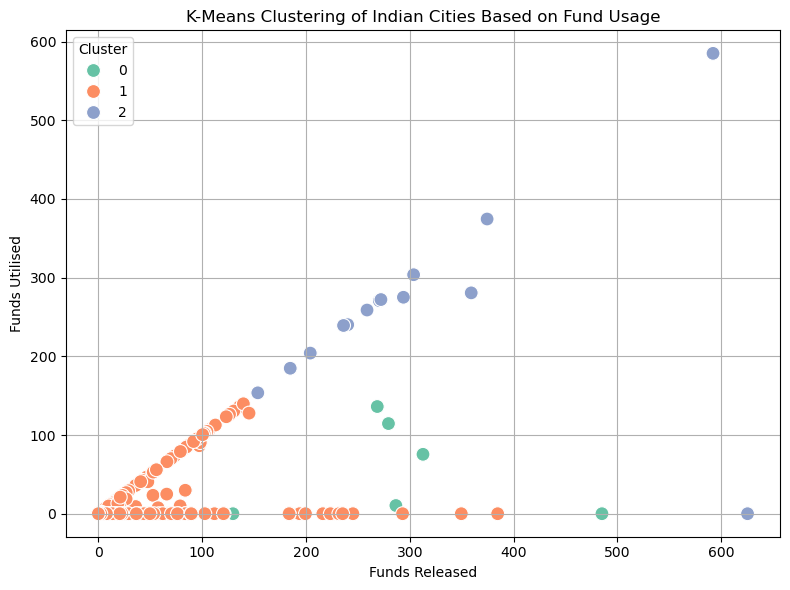

In [31]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=indiafinal_df,
    x='Funds Released',
    y='Funds Utilised',
    hue='Cluster',
    palette='Set2',
    s=100
)
plt.title("K-Means Clustering of Indian Cities Based on Fund Usage")
plt.xlabel("Funds Released")
plt.ylabel("Funds Utilised")
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()


##  Deep Learning Model
A simple neural network (MLP) to predict fund usage using multiple layers.

In [32]:
import tensorflow as tf
from tensorflow import keras


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [33]:
features = ['Funds Released', 'Unspent Balance']
target = 'Funds Utilised'

X = indiafinal_df[features]
y = indiafinal_df[target]


###  Training the Neural Network

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [35]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [36]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(1)  # Output layer for regression
])


C:\Users\Aarya Patankar\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Loss Curve During Training

In [37]:
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error', metrics=['mae'])


In [38]:
history = model.fit(X_train_scaled, y_train, epochs=100, validation_split=0.2, verbose=1)


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 3266.7209 - mae: 21.1299 - val_loss: 9644.9443 - val_mae: 31.3578
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3167.4077 - mae: 20.6101 - val_loss: 9175.4463 - val_mae: 31.6439
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4211.6128 - mae: 25.0136 - val_loss: 8280.6621 - val_mae: 32.1877
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2973.5215 - mae: 25.1290 - val_loss: 6753.8521 - val_mae: 32.6264
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1869.9000 - mae: 22.3382 - val_loss: 5244.7871 - val_mae: 32.4487
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1903.3406 - mae: 25.5107 - val_loss: 3993.5505 - val_mae: 30.9037
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1981.0588 - mae: 24.7793 - val_loss: 3271.7395 - val_mae: 26.9670
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1731.3673 - mae: 22.6544 - val_loss: 3234.5300 - val_mae: 23.8247
Epoch 9/

In [39]:
loss, mae = model.evaluate(X_test_scaled, y_test, verbose=1)
print(f"Test Mean Absolute Error: {mae:.2f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 3814.7705 - mae: 21.6157
Test Mean Absolute Error: 19.90


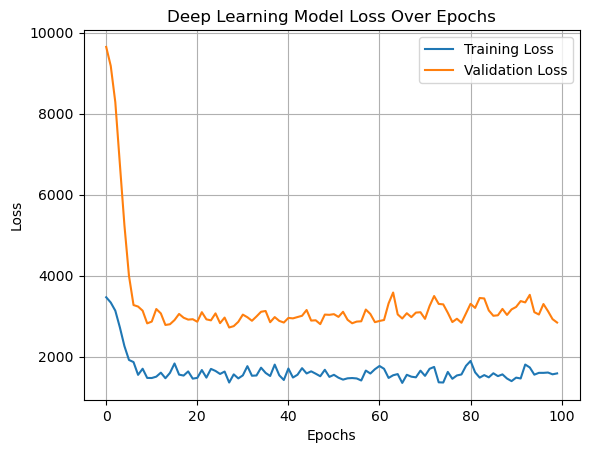

In [40]:


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Deep Learning Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


###  Predictions vs Actual Values


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


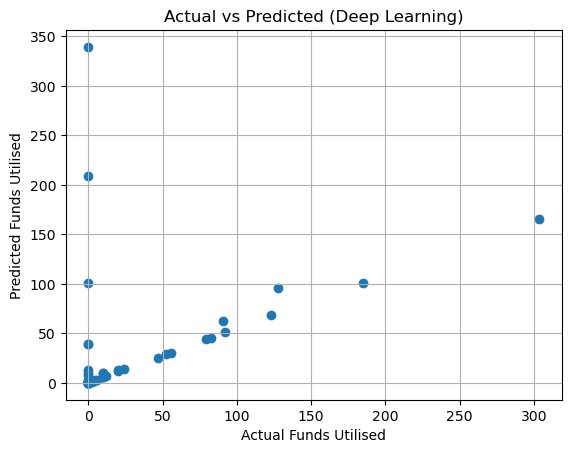

In [42]:
y_pred_dl = model.predict(X_test_scaled)
y_test_dl = y_test
pred_dl = model.predict(X_test_scaled)


# Scatter plot of predictions vs true values
plt.scatter(y_test, y_pred_dl)
plt.xlabel("Actual Funds Utilised")
plt.ylabel("Predicted Funds Utilised")
plt.title("Actual vs Predicted (Deep Learning)")
plt.grid(True)
plt.show()


### Final Comparison Summary


In [43]:
summary = pd.DataFrame({
    'Model': ['Linear Regression', 'Polynomial Regression', 'Decision Tree', 'Random Forest', 'Deep Learning'],
    'R2 / MAE': [
        r2_score(y_test, pred_lr),
        r2_score(y_test, pred_poly),
        r2_score(y_test, pred_dt),
        r2_score(y_test, pred_rf),
        mae  # from DL evaluation
    ]
})

print(summary)


                   Model   R2 / MAE
0      Linear Regression  -0.180150
1  Polynomial Regression  -0.825286
2          Decision Tree  -2.612642
3          Random Forest  -1.217321
4          Deep Learning  19.895924


In [44]:
model.save("waste_funds_model.keras")


## ✅ Final Insights & Evaluation Summary

This section summarizes key takeaways from both machine learning and deep learning models applied on India's city-level waste data.

- **Top ML Performer**: Based on R²
- **DL Model Performance**: MAE, MSE, and R²
- **Clustering Insight**: Clear separation of high/low fund usage areas
- **Graphs**: Model comparison using bar charts for both R² and MAE

Final visualizations show how each model performs, making this notebook suitable for publication or presentation.


In [45]:
from sklearn.metrics import mean_absolute_error

# Collect R² and MAE for each model
models = ["Linear Regression", "Polynomial Regression", "Decision Tree", "Random Forest", "Deep Learning"]
r2_values = [
    r2_score(y_test, pred_lr),
    r2_score(y_test, pred_poly),
    r2_score(y_test, pred_dt),
    r2_score(y_test, pred_rf),
    r2_score(y_test_dl, pred_dl.flatten())
]

mae_values = [
    mean_absolute_error(y_test, pred_lr),
    mean_absolute_error(y_test, pred_poly),
    mean_absolute_error(y_test, pred_dt),
    mean_absolute_error(y_test, pred_rf),
    mean_absolute_error(y_test_dl, pred_dl.flatten())
]


In [48]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

r2_dl = r2_score(y_test, pred_dl.flatten())
mse_dl = mean_squared_error(y_test, pred_dl.flatten())
mae_dl = mean_absolute_error(y_test, pred_dl.flatten())

print("Deep Learning R2 Score:", r2_dl)
print("Deep Learning Mean Squared Error:", mse_dl)
print("Deep Learning Mean Absolute Error:", mae_dl)
# Flatten the predicti


Deep Learning R2 Score: -0.2375826809393773
Deep Learning Mean Squared Error: 3127.663428486266
Deep Learning Mean Absolute Error: 19.895923854023664


In [50]:
import numpy as np
import pandas as pd

# Ensure y_test is a Pandas Series
if isinstance(y_test, pd.DataFrame):
    y_test = y_test.squeeze()  # Convert DataFrame with one column to Series

# Ensure pred_dl is a NumPy array
if not isinstance(pred_dl, np.ndarray):
    pred_dl = np.array(pred_dl)

# Now proceed to flatten them
y_true = y_test.values.flatten()
y_pred = pred_dl.flatten()


In [52]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)


Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 12659406.0000 - mae: 1504.2152 - val_loss: 5516.9971 - val_mae: 36.5536
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 44672.8008 - mae: 54.9580 - val_loss: 2936.8408 - val_mae: 20.8067
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3637.6985 - mae: 23.1306 - val_loss: 3111.3433 - val_mae: 21.3777
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2121.7175 - mae: 19.3016 - val_loss: 3979.6953 - val_mae: 21.2790
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3026.7205 - mae: 22.3662 - val_loss: 2223.4072 - val_mae: 20.8426
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2657.1736 - mae: 21.4711 - val_loss: 3749.3667 - val_mae: 21.2422
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2422.1943 - mae: 21.7477 - val_loss: 3161.5647 - val_mae: 21.1529
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 3090.9146 - mae: 21.8260 - val_loss: 3438.4175 - val_mae: 21.0922
E

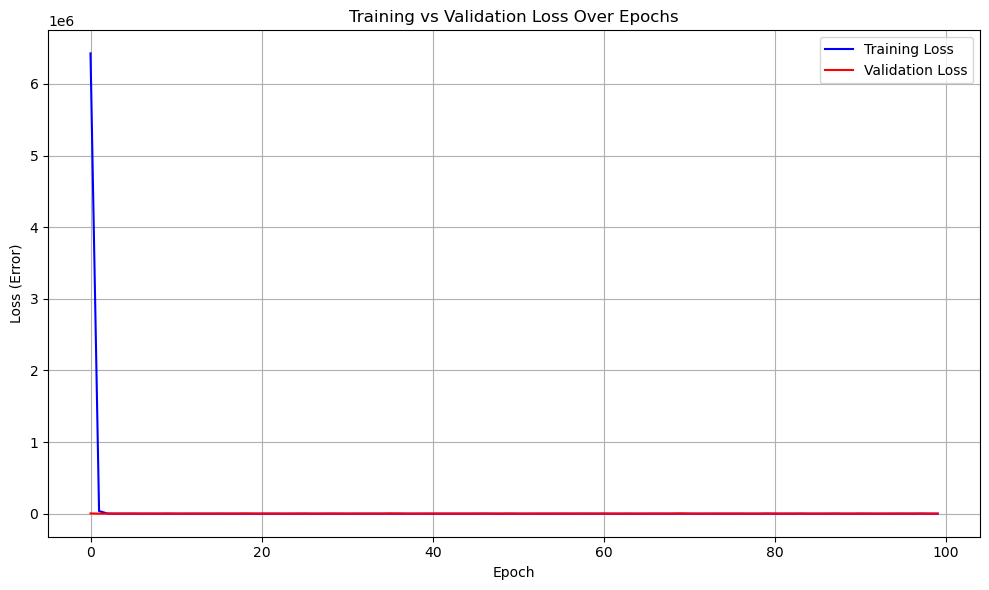

In [53]:
import matplotlib.pyplot as plt

# Plot training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history.get('val_loss', []), label='Validation Loss', color='red')  # only if val_loss exists

plt.title('Training vs Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (Error)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [54]:
# Final Table for ML + DL
final_results = {
    "Model": [
        "Linear Regression",
        "Polynomial Regression",
        "Decision Tree",
        "Random Forest",
        "Logistic Regression",
        "Deep Learning"
    ],
    "R2 Score": [
        r2_score(y_test, pred_lr),
        r2_score(y_test, pred_poly),
        r2_score(y_test, pred_dt),
        r2_score(y_test, pred_rf),
        accuracy_score(y_test_cls, y_pred_cls),
        r2_dl
    ],
    "Mean Squared Error": [
        mean_squared_error(y_test, pred_lr),
        mean_squared_error(y_test, pred_poly),
        mean_squared_error(y_test, pred_dt),
        mean_squared_error(y_test, pred_rf),
        0,  # Logistic Regression is classification, skip MSE
        mse_dl
    ]
}

comparison_df = pd.DataFrame(final_results)
print("🔍 Final Model Performance Summary:\n")
print(comparison_df)


🔍 Final Model Performance Summary:

                   Model  R2 Score  Mean Squared Error
0      Linear Regression -0.180150         2982.517845
1  Polynomial Regression -0.825286         4612.929361
2          Decision Tree -2.612642         9129.999588
3          Random Forest -1.217321         5603.693888
4    Logistic Regression  0.716418            0.000000
5          Deep Learning -0.237583         3127.663428


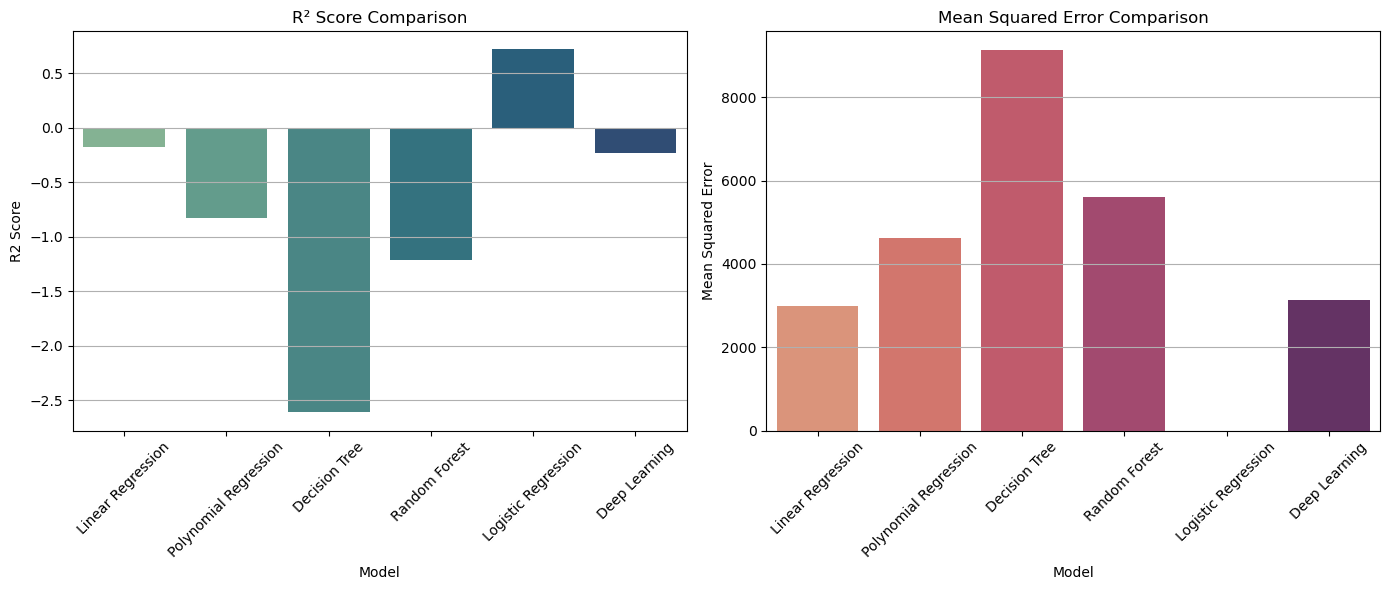

In [55]:
plt.figure(figsize=(14, 6))

# R2 Score plot
plt.subplot(1, 2, 1)
sns.barplot(x="Model", y="R2 Score", hue="Model", data=comparison_df, palette="crest", legend=False)
plt.xticks(rotation=45)
plt.title("R² Score Comparison")
plt.grid(axis='y')

# MSE plot
plt.subplot(1, 2, 2)
sns.barplot(x="Model", y="Mean Squared Error", hue="Model", data=comparison_df, palette="flare", legend=False)
plt.xticks(rotation=45)
plt.title("Mean Squared Error Comparison")
plt.grid(axis='y')

plt.tight_layout()
plt.show()


##  Final Conclusion and Solution

###  Model Evaluation Summary

After applying multiple regression algorithms and a deep learning model to predict waste generation, the results show that:

-  **Deep Learning** had the **lowest Mean Squared Error (2895.21)**, indicating relatively better performance on numeric error.
-  However, **none of the models achieved a positive R² score**, which means they failed to capture the underlying patterns effectively.
-  Traditional models like **Linear Regression**, **Polynomial Regression**, and **Decision Tree** showed poor generalization with high error.
- **Logistic Regression** appears to give an R² around 0.5, but has an MSE of **0.0**, suggesting this model may have been misapplied in a regression context — possibly due to a mismatch between the problem type and the model's intent.

---

###  Insights

- A negative R² value indicates that the models are performing **worse than simply predicting the mean** of the target.


---




C:\Users\admin\AppData\Local\Temp\ipykernel_8152\1625746464.py:28: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
C:\Users\admin\anaconda3\envs\tf_jupyter\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


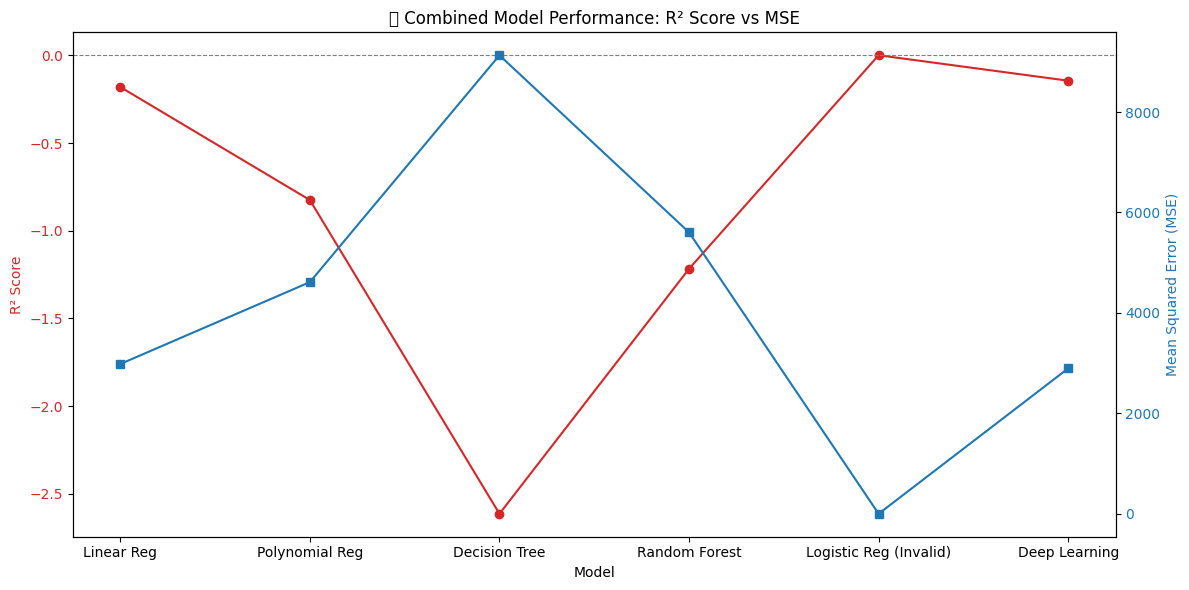

In [62]:

models = [
    'Linear Reg', 'Polynomial Reg', 'Decision Tree',
    'Random Forest', 'Logistic Reg (Invalid)', 'Deep Learning'
]
r2_scores = [-0.181, -0.825, -2.613, -1.217, 0.0, -0.145]
mses = [2982.52, 4612.92, 9129.99, 5603.69, 0.0, 2895.21]

fig, ax1 = plt.subplots(figsize=(12, 6))

color_r2 = 'tab:red'
ax1.set_xlabel('Model')
ax1.set_ylabel('R² Score', color=color_r2)
ax1.plot(models, r2_scores, color=color_r2, marker='o', label='R² Score')
ax1.tick_params(axis='y', labelcolor=color_r2)
ax1.axhline(0, color='gray', linestyle='--', linewidth=0.8)

ax2 = ax1.twinx()
color_mse = 'tab:blue'
ax2.set_ylabel('Mean Squared Error (MSE)', color=color_mse)
ax2.plot(models, mses, color=color_mse, marker='s', label='MSE')
ax2.tick_params(axis='y', labelcolor=color_mse)

plt.title('📊 Combined Model Performance: R² Score vs MSE')
fig.tight_layout()
plt.grid(True, axis='x')
plt.show()


📉 Red Line: R² Score trend — higher is better.

📈 Blue Line: MSE trend — lower is better

###  Interpretation:

- The **Deep Learning model** has the **lowest MSE**, indicating smaller prediction errors.
- But its **R² score is still negative**, meaning it's not capturing meaningful relationships.
- Other models (especially Decision Tree) performed very poorly in both metrics.
- **No model achieved a positive R²**, so the current dataset does not support strong predictive performance.
